### Problem Description

 https://www.kaggle.com/snap/amazon-fine-food-reviews
 We have dataset abput food review and we have to build a model to predict if the customer reviews is positive or negative.... we have text reviews of some customers in our dataset and we have to do some analysis on it to help model to predict well and to improve the accuracy of the model.
 On this notebook you will see some analysis on the dataset and the prediction model.

### Import Packages

In [478]:
!pip3 install gensim==3.8.3

In [479]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LapStor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LapStor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LapStor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read Dataset

In [480]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 4.85 s


In [481]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [482]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [483]:
df_text.shape

(568454, 2)

### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [484]:
df_text=df_text.drop_duplicates()

In [485]:
df_text = df_text.reset_index(drop=True)## Write your code here

In [486]:
df_text.shape

(393675, 2)

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [487]:
df_text['target'] =df_text.Score.apply(lambda x:0 if x < 3 else 1 )## Write your code here
df_text.head(5)

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


In [488]:
df_text['target'].value_counts()

1    336591
0     57084
Name: target, dtype: int64

#### Plot Countplot for target Variable

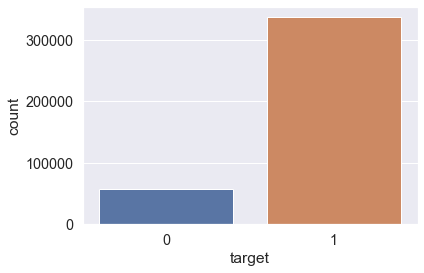

In [489]:
sns.countplot(x ='target',data = df_text) 
#plt.ylim(0, 8000)
plt.show()## Write your code here

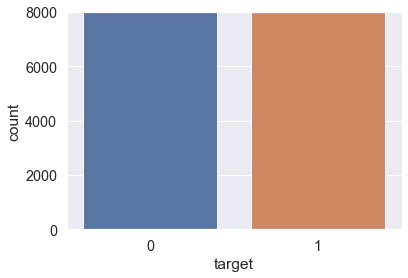

In [490]:
sns.countplot(x ='target',data = df_text) 
plt.ylim(0, 8000)
plt.show()## Write your code here

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [491]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

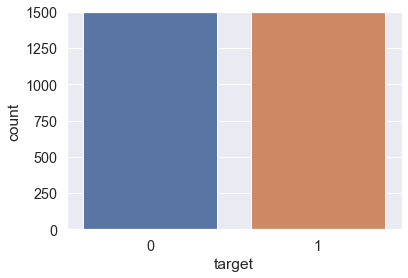

In [492]:
sns.countplot(x ='target',data = df_text_balanced) 
plt.ylim(0,1500)
plt.show()## Write your code here## PLot the target again after balancing
## Write your code here

### Text Pre-Processing

In [493]:
#stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer("english")
#lemmatizer= WordNetLemmatizer()

In [494]:
## Clean your reviews using stemmer, lemmatizer & stopwords

In [495]:
df_text_balanced['Text']= df_text_balanced['Text'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))
df_text_balanced['Text'] = df_text_balanced['Text'].str.lower()

In [496]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df_text_balanced['Text']=df_text_balanced['Text'].apply(lambda text:remove_stopwords(text))

In [497]:
df_text_balanced.head(5)

,Text,Score,target
86808,brownie mix creates dense chewy chocolatey del...,5,1
90381,sugary mixes well cold water doesnt come solut...,5,1
142101,forgotten good actually little goes long way e...,5,1
246275,toddler cannot drink cows milk related product...,5,1
31090,highly recommend hibiscus tea davidsons wonder...,5,1


In [498]:
from nltk.tokenize import sent_tokenize,word_tokenize
df_text_balanced['text_tokens'] =df_text_balanced['Text'].apply(lambda x: word_tokenize(x))
df_text_balanced.head(5)

,Text,Score,target,text_tokens
86808,brownie mix creates dense chewy chocolatey del...,5,1,"[brownie, mix, creates, dense, chewy, chocolat..."
90381,sugary mixes well cold water doesnt come solut...,5,1,"[sugary, mixes, well, cold, water, doesnt, com..."
142101,forgotten good actually little goes long way e...,5,1,"[forgotten, good, actually, little, goes, long..."
246275,toddler cannot drink cows milk related product...,5,1,"[toddler, can, not, drink, cows, milk, related..."
31090,highly recommend hibiscus tea davidsons wonder...,5,1,"[highly, recommend, hibiscus, tea, davidsons, ..."


In [499]:
lemmatizer= WordNetLemmatizer()
def text_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
df_text_balanced['text_tokens_lemma'] = df_text_balanced['text_tokens'].apply(lambda x: text_lemmatizer(x))
df_text_balanced.head(5)

,Text,Score,target,text_tokens,text_tokens_lemma
86808,brownie mix creates dense chewy chocolatey del...,5,1,"[brownie, mix, creates, dense, chewy, chocolat...","[brownie, mix, creates, dense, chewy, chocolat..."
90381,sugary mixes well cold water doesnt come solut...,5,1,"[sugary, mixes, well, cold, water, doesnt, com...","[sugary, mix, well, cold, water, doesnt, come,..."
142101,forgotten good actually little goes long way e...,5,1,"[forgotten, good, actually, little, goes, long...","[forgotten, good, actually, little, go, long, ..."
246275,toddler cannot drink cows milk related product...,5,1,"[toddler, can, not, drink, cows, milk, related...","[toddler, can, not, drink, cow, milk, related,..."
31090,highly recommend hibiscus tea davidsons wonder...,5,1,"[highly, recommend, hibiscus, tea, davidsons, ...","[highly, recommend, hibiscus, tea, davidsons, ..."


In [500]:
stemmer = SnowballStemmer("english")
def text_stemmer(text):
    stem_text = [SnowballStemmer("english").stem(i) for i in text]
    return stem_text
df_text_balanced['text_tokens_stem'] =df_text_balanced['text_tokens_lemma'].apply(lambda x: text_stemmer(x))
df_text_balanced.head(5)

,Text,Score,target,text_tokens,text_tokens_lemma,text_tokens_stem
86808,brownie mix creates dense chewy chocolatey del...,5,1,"[brownie, mix, creates, dense, chewy, chocolat...","[brownie, mix, creates, dense, chewy, chocolat...","[browni, mix, creat, dens, chewi, chocolatey, ..."
90381,sugary mixes well cold water doesnt come solut...,5,1,"[sugary, mixes, well, cold, water, doesnt, com...","[sugary, mix, well, cold, water, doesnt, come,...","[sugari, mix, well, cold, water, doesnt, come,..."
142101,forgotten good actually little goes long way e...,5,1,"[forgotten, good, actually, little, goes, long...","[forgotten, good, actually, little, go, long, ...","[forgotten, good, actual, littl, go, long, way..."
246275,toddler cannot drink cows milk related product...,5,1,"[toddler, can, not, drink, cows, milk, related...","[toddler, can, not, drink, cow, milk, related,...","[toddler, can, not, drink, cow, milk, relat, p..."
31090,highly recommend hibiscus tea davidsons wonder...,5,1,"[highly, recommend, hibiscus, tea, davidsons, ...","[highly, recommend, hibiscus, tea, davidsons, ...","[high, recommend, hibiscus, tea, davidson, won..."


In [501]:
df_text_balanced.drop(['text_tokens', 'text_tokens_lemma'], axis='columns', inplace=True)

In [502]:
df_text_balanced['Text']=df_text_balanced['text_tokens_stem'].str.join(' ')

In [503]:
df_text_balanced.drop(['text_tokens_stem'], axis='columns', inplace=True)

In [504]:
df_text_balanced.head(5)

,Text,Score,target
86808,browni mix creat dens chewi chocolatey delici ...,5,1
90381,sugari mix well cold water doesnt come solut d...,5,1
142101,forgotten good actual littl go long way easi u...,5,1
246275,toddler can not drink cow milk relat product h...,5,1
31090,high recommend hibiscus tea davidson wonder la...,5,1


### Split Test & Training Data

In [505]:
X =df_text_balanced['Text']## Write your code here
y =df_text_balanced['target'] ## Write your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [506]:
## TFIDF embedding for the Description
vectorizer =TfidfVectorizer()## Write your code here
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf =vectorizer.fit(X_train) ## Write your code here
# transform on training data
X_train =vectorizer_tfidf.fit_transform(X_train)## Write your code here
## Write your code here
# transform on testing data
X_test = vectorizer.transform(X_test)## Write your code here
 ## Write your code here

In [507]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 73003), (34251, 73003))

### Modelling

In [508]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [509]:
## initialize your Model
clf =RandomForestClassifier() 
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 83.83%


### Raw Instance Prediction

In [510]:
def cleaning (review):
    review_c=[]
    review_1=word_tokenize(review)
    for i in review_1:
        if i.lower() not in stop_words:
            re_review=re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
            review_s=SnowballStemmer('english').stem(re_review)
            review_c.append(review_s)
    return " ".join(review_c)

In [511]:
from sklearn.feature_extraction.text import TfidfVectorizer
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c =cleaning(review)
    # Embed review using tf-idf vectorizer
    embedding =vectorizer.transform([review_c])
    # Predict using your model
    prediction =model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [512]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [513]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [514]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [515]:
import pickle

In [516]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

model=pickle.dump(clf, open(model_name, 'wb'))## Save model
vectorizer=pickle.dump(vectorizer, open(vectorizer_name, 'wb'))## Save tfidf-vectorizer

### Load model Again and test them

In [517]:
loaded_model =pickle.load(open('rf_model.pk', 'rb'))
loaded_vect = pickle.load(open('tfidf_vectorizer.pk', 'rb'))

In [518]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [519]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework